In [1]:
using ApproxFun
using SpecialFunctions

using LinearAlgebra
using SparseArrays

include("../src/Chebyshev.jl")
import .Chebyshev as CH

import Plots
using Plots

# use PyCall
using PyCall
@pyimport qnm

import HDF5


# Teukolsky Radial Equation

In [2]:
function radial_operator(
    nr::Integer,
    s::Integer,
    m::Integer,
    a::T,
    bhm::T,
    om::Complex{T},
    gamma::Complex{T},
    rmin::T,
    rmax::T,
) where {T<:Real}
    d = rmin..rmax;
    D1 = Derivative(d);
    D2 = D1^2;
    x = Fun(identity,d);

    A = (
        (2 * im) * om - 2 * (1 + s) * x +
        2 * (im * om * ((a^2) - 8 * (bhm^2)) + im * m * a + (s + 3) * bhm) * x^2 +
        4 * (2 * im * om * bhm - 1) * (a^2) * x^3
    )
    B = (
        (((a^2) - 16 * (bhm^2)) * (om^2) + 2 * (m * a + 2 * im * s * bhm) * om) +
        2 *
        (
            4 * ((a^2) - 4 * (bhm^2)) * bhm * (om^2) +
            (4 * m * a * bhm - 4 * im * (s + 2) * (bhm^2) + im * (a^2)) * om +
            im * m * a +
            (s + 1) * bhm
        ) *
        x +
        2 * (8 * (bhm^2) * (om^2) + 6 * im * bhm * om - 1) * (a^2) * x^2
    )
    return (-(x^2 - 2 * bhm * x^3 + (a^2) * x^4) * D2 + A * D1 + (B + gamma))[1:nr,1:nr]
end;

In [130]:
# input params

nr = 120
s = -2;
l = 2;
m = 2;
n = 12;
T=Float64
a = T(0.)
bhm = T(1)

rmin = T(0) ## location of future null infinity (1/r = ∞)
rmax = abs(a) > 0 ? (bhm / (a^2)) * (1 - sqrt(1 - ((a / bhm)^2))) : 0.5 / bhm

0.5

In [131]:
mode_seq = qnm.modes_cache(s=s,l=l,m=m,n=n);
omega, gamma, C = mode_seq(a=a);

In [132]:
rs = CH.cheb_pts(rmin,rmax,nr);

In [133]:
M = radial_operator(nr,s,m,a,bhm,omega,gamma,rmin,rmax);

In [146]:
null = nullspace(Matrix(M),rtol=5e-17);

In [147]:
length(null)

120

In [150]:
vect = CH.to_real(null[:,1]);

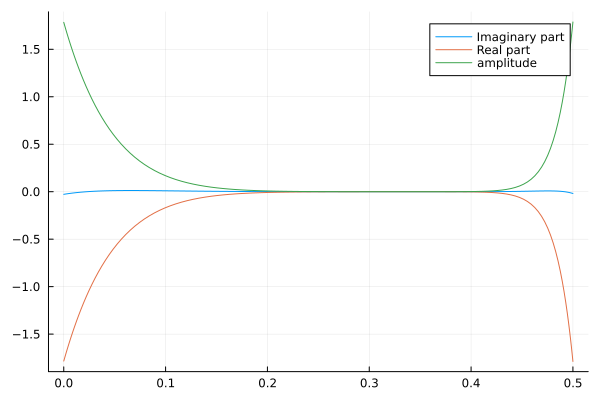

In [151]:
Plots.plot(rs,[v.im for v in vect],label="Imaginary part")
Plots.plot!(rs,[v.re for v in vect],label="Real part")
Plots.plot!(rs,[abs(v) for v in vect],label="amplitude")


# Save the resulting files

In [70]:
function save_to_file!(
    prename::String,
    n::Integer,
    l::Integer,
    m::Integer,
    a::T,
    omega::Complex{T},
    lambda::Complex{T},
    vr::Vector{<:Complex{T}},
    rs::Vector{<:T},
) where {T<:Real}
    fname = "$(pwd())/qnmfiles/$(prename)a$(a)_l$(l)_m$(m)_n$(n)"
    HDF5.h5open("$fname.h5", "cw") do file
        g = HDF5.create_group(file, "[a=$(convert(Float64,a)),l=$(convert(Int64,l))]")
        g["nr"] = convert(Int64, length(rs))
        g["omega"] = convert(ComplexF64, omega)
        g["lambda"] = convert(ComplexF64, lambda)
        g["radial_func"] = [convert(ComplexF64, v) for v in vr]
        g["rvals"] = [convert(Float64, v) for v in rs]
    end
    return nothing
end;

In [71]:
save_to_file!("",n,l,m,a,omega,gamma,vect,rs)